Code for **"Blind restoration of a JPEG-compressed image"** and **"Blind image denoising"** figures. Select `fname` below to switch between the two.

- To see overfitting set `num_iter` to a large value.

In [ ]:
#Test convolution
import torch
kernel = torch.randn(3,3,5,5).type(torch.cuda.DoubleTensor)
image = torch.randn(1,3,256,256).type(torch.cuda.DoubleTensor)
print(image.dtype)
out_image = torch.nn.functional.conv2d(image,kernel, padding =2)
print(out_image.dtype)
print(out_image.shape)

torch.float64
torch.float64
torch.Size([1, 3, 256, 256])


In [1]:
"""
*Uncomment if running on colab* 
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab 
"""
!git clone https://github.com/maxudong1993/deep-image-prior.git
!mv deep-image-prior/* ./

Cloning into 'deep-image-prior'...
remote: Enumerating objects: 842, done.
remote: Counting objects: 100% (306/306), done.
remote: Compressing objects: 100% (266/266), done.
remote: Total 842 (delta 147), reused 87 (delta 38), pack-reused 536
Receiving objects: 100% (842/842), 144.50 MiB | 24.01 MiB/s, done.
Resolving deltas: 100% (435/435), done.


In [2]:
!ls ./

activation_maximization.ipynb
Average_loss_clock.ipynb
data
deep-image-prior
denoising.ipynb
Dockerfile
environment.yml
estimatePSF.m
feature_inversion.ipynb
flash-no-flash.ipynb
inpainting.ipynb
LICENSE
Line_SensorGain_PSFconv_L1norm_UMCamp.ipynb
Line_SensorGain_PSFconv_lossnorm_UMCamp.ipynb
models
mydenoising.ipynb
mydenoisingSensorGain_clock.ipynb
mydenoisingSensorGain.ipynb
mydenoisingSensorGain_UM_camp.ipynb
mydenoisingTest.ipynb
README.md
restoration.ipynb
sample_data
SensorGain.m
SensorGain_PSFconv_FroNorm_clock.ipynb
SensorGain_PSFconv_L1norm_clock.ipynb
SensorGain_PSFconv_L1norm_UMCamp.ipynb
SensorGain_PSFconv_L2norm_clock.ipynb
SensorGain_PSFconv_on_Output_clock.ipynb
SensorGain_PSFconv_on_output_UM_camp.ipynb
SensorGain_PSFconv_on_output_USMR..ipynb
SensorGain_SimpleDeconv_clock.ipynb
SensorGain_SimpleDeconv_MRUS.ipynb
SensorGain_SimpleDeconv_UM_Camp.ipynb
SensorGain_SimpleDeconv_USMR_Weighting.ipynb
sr_net_L1loss_noNorm_clock.ipynb
sr_net_L2loss_noNorm_clock.ipynb
sr_net_L2

# Import libs

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline
import inspect

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
from models import *

import torch
import torch.optim

from skimage.measure import compare_psnr
from utils.denoising_utils import *

#?enable best algorithm for hardware  
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor
# dtype = torch.cuda.DoubleTensor

imsize =-1
PLOT = True
sigma = 25
sigma_ = sigma/255.

In [73]:
#Save the input images as gray image
image_path = '/content/data/data/medical/'
image1_pil = get_image(fname_us, imsize)[0]
image2_pil = get_image(fname_mr, imsize)[0]
print(image1_pil)
#3 channels of gray images are almost the same, so only keep one channel
image1_np = pil_to_np(image1_pil)[0][None,:]
image2_np = pil_to_np(image2_pil)[0][None,:]
image1 = np_to_pil(image1_np).save(image_path+'grayMed1.jpg')
image2 = np_to_pil(image2_np).save(image_path+'grayMed2.jpg')
print(image1_np.shape)


<PIL.BmpImagePlugin.BmpImageFile image mode=L size=256x256 at 0x7FE2039226D0>


In [72]:
## UM
fname_us = '/content/data/data/UN camp/UNcamp_2N_i_20.bmp'
fname_mr = '/content/data/data/UN camp/UNcamp_2N_v_20.bmp'
# fname_us = '/content/data/data/clocks/clockA.jpg'
# fname_mr = '/content/data/data/clocks/clockB.jpg'
# fname_us = 'data/denoising/VIS1.png'
# fname_mr = 'data/denoising/IR1.png'
# fname_us = '/content/data/data/medical/grayMed1.jpg'
# fname_mr = '/content/data/data/medical/grayMed2.jpg'

# fname_us = 'data/denoising/clock1.jpg'
# fname_mr = 'data/denoising/clock2.jpg'
iName = 'UNCamp'
channels = 128
RGB = False #if the image is RGB model
output_path = ('/content/data/data/UN camp/gray'+iName+'_input'+str(channels)+'_'+str(channels)+'channelavg.png')
# fname_us, fname_mr = samesize_images(fname_us, fname_mr) #BiCubic magtify

print(fname_us)
print(fname_mr)
# print(inspect.getsourcefile(pil_to_np))

/content/data/data/UN camp/UNcamp_2N_i_20.bmp
/content/data/data/UN camp/UNcamp_2N_v_20.bmp


# Load MR and US, as well as deconvolution


In [73]:
#Estimate PSF and H
import skimage.restoration as rst
import scipy
us_noisy_pil = crop_image(get_image(fname_us, imsize)[0], d=1)
us_noisy_np = pil_to_np(us_noisy_pil)
us_noisy_np = np.broadcast_to(us_noisy_np,[channels,us_noisy_np.shape[1],us_noisy_np.shape[2]])
print('us_noisy_np.shape:',us_noisy_np.shape)

mr_noisy_pil = crop_image(get_image(fname_mr, imsize)[0], d=1)
mr_noisy_np = pil_to_np(mr_noisy_pil)
mr_noisy_np = np.broadcast_to(mr_noisy_np,[channels,mr_noisy_np.shape[1],mr_noisy_np.shape[2]])
print('mr_noisy_np.shape:',mr_noisy_np.shape)

psf_size = [5,5]
if RGB == True:
    us_H_r, us_psf_r = estimatePSF(us_noisy_np[0], psf_size)
    mr_H_r, mr_psf_r = estimatePSF(mr_noisy_np[0], psf_size)
    us_psf_r = us_psf_r/np.sum(us_psf_r)
    mr_psf_r = mr_psf_r/np.sum(mr_psf_r)
    # us_psf_torch_r = torch.FloatTensor(us_psf_r).expand(1,3,psf_size[0],psf_size[1])
    # mr_psf_torch_r = torch.FloatTensor(mr_psf_r).expand(1,3,psf_size[0],psf_size[1])

    us_H_g, us_psf_g = estimatePSF(us_noisy_np[1], psf_size)
    mr_H_g, mr_psf_g = estimatePSF(mr_noisy_np[1], psf_size)
    us_psf_g = us_psf_g/np.sum(us_psf_g)
    mr_psf_g = mr_psf_g/np.sum(mr_psf_g)
    # us_psf_torch_g = torch.FloatTensor(us_psf_g).expand(1,3,psf_size[0],psf_size[1])
    # mr_psf_torch_g = torch.FloatTensor(mr_psf_g).expand(1,3,psf_size[0],psf_size[1])

    us_H_b, us_psf_b = estimatePSF(us_noisy_np[2], psf_size)
    mr_H_b, mr_psf_b = estimatePSF(mr_noisy_np[2], psf_size)
    us_psf_b = us_psf_b/np.sum(us_psf_b)
    mr_psf_b = mr_psf_b/np.sum(mr_psf_b)
    # us_psf_torch_b = torch.FloatTensor(us_psf_b).expand(1,3,psf_size[0],psf_size[1])
    # mr_psf_torch_b = torch.FloatTensor(mr_psf_b).expand(1,3,psf_size[0],psf_size[1])

    # us_psf_torch = torch.cat((us_psf_torch_r,us_psf_torch_g,us_psf_torch_b),0).type(dtype).to(device = 'cuda')
    # mr_psf_torch = torch.cat((mr_psf_torch_r,mr_psf_torch_g,mr_psf_torch_b),0).type(dtype).to(device = 'cuda')
    us_psf_np = np.array([us_psf_r, us_psf_g, us_psf_b])
    mr_psf_np = np.array([mr_psf_r, mr_psf_g, mr_psf_b])
    us_psf_torch = np_to_torch(us_psf_np).type(dtype).to(device = 'cuda')
    mr_psf_torch = np_to_torch(mr_psf_np).type(dtype).to(device = 'cuda')
    print('3 channels. us_psf_torch.shape:',us_psf_torch.shape)

else:
    us_H, us_psf = estimatePSF(us_noisy_np[0], psf_size)
    mr_H, mr_psf = estimatePSF(mr_noisy_np[0], psf_size)
    us_psf = us_psf/np.sum(us_psf)
    mr_psf = mr_psf/np.sum(mr_psf)

    us_psf_np = us_psf[None,:] #numpy is [1,*,*] rather than [*,*]
    mr_psf_np = mr_psf[None,:]
    us_psf_np = np.broadcast_to(us_psf_np,[channels,us_psf_np.shape[1],us_psf_np.shape[2]])
    mr_psf_np = np.broadcast_to(mr_psf_np,[channels,mr_psf_np.shape[1],mr_psf_np.shape[2]])

    us_psf_torch = np_to_torch(us_psf_np).type(dtype).to(device = 'cuda')
    mr_psf_torch = np_to_torch(mr_psf_np).type(dtype).to(device = 'cuda')
    print(channels,' channel. us_psf_torch.shape:',us_psf_torch.shape)

#torch convolution
# a = torch.nn.functional.conv2d(us_noisy_torch,us_psf_torch,padding = 2)


#cannot operation on GPU, but pytorch has convolution operation
# us_after_psf = scipy.ndimage.filters.correlate(us_noisy_np[0], us_psf, mode='mirror')[None,:,:] 
# us_after_psf = scipy.ndimage.filters.convolve(us_noisy_np[0], us_psf, mode='mirror')[None,:,:]
# plot_image_grid([us_noisy_np,us_after_psf], 4, 5) #should be blurer, cause this is operation on output rather than input


#Deconvolution richardson_lucy

# deconvolved_us = rst.richardson_lucy (us_noisy_np[0,:,:], us_psf, iterations=5)[None,:,:] #deconvolution
# deconvolved_mr = rst.richardson_lucy (mr_noisy_np[0,:,:], mr_psf, iterations=5)[None,:,:]

# plot_image_grid([us_noisy_np,deconvolved_us], 4, 5)
# plot_image_grid([mr_noisy_np,deconvolved_mr], 4, 5)

# #original images
# o_us_np = us_noisy_np 
# o_mr_np = mr_noisy_np

# us_noisy_np = deconvolved_us
# us_noisy_pil = np_to_pil(deconvolved_us)
# mr_noisy_np = deconvolved_mr
# mr_noisy_pil = np_to_pil(deconvolved_mr)


us_noisy_np.shape: (128, 256, 256)
mr_noisy_np.shape: (128, 256, 256)
128  channel. us_psf_torch.shape: torch.Size([1, 128, 5, 5])


/usr/local/lib/python3.7/dist-packages/pywt/_multilevel.py:45: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


# **Compute sensor gain**

(256, 256)
us_sg_np shape: (128, 256, 256)
us_sg_torch shape: torch.Size([1, 128, 256, 256])


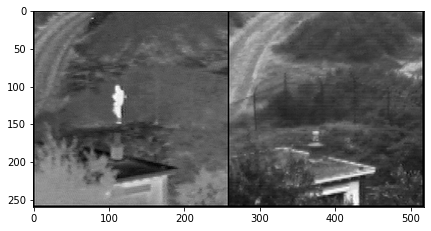

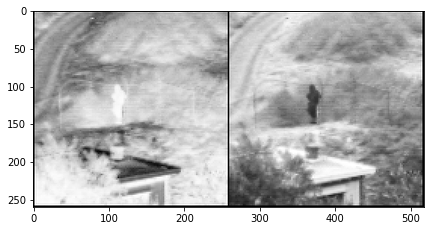

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.7060691 , ..., 0.82992616,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.97516515, ..., 0.33458276,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.7060691 , ..., 0.82992616,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.97516515, ..., 0.33458276,
         0.        , 0.        ],
        [0. 

In [74]:
# As we don't have ground truth
us_pil = us_noisy_pil
us_np = us_noisy_np

mr_pil = mr_noisy_pil
mr_np = mr_noisy_np

#compute sensor gain
# sensor_gain
if RGB == True:
    us_sg_r, mr_sg_r = sensor_gain(us_np[0],mr_np[0],mbSize=1)
    us_sg_g, mr_sg_g = sensor_gain(us_np[1],mr_np[1],mbSize=1)
    us_sg_b, mr_sg_b = sensor_gain(us_np[2],mr_np[2],mbSize=1)
    us_sg_np = np.array([us_sg_r, us_sg_g, us_sg_b])
    mr_sg_np = np.array([mr_sg_r, mr_sg_g, mr_sg_b])
else:
    us_sg, mr_sg = sensor_gain(us_np[0],mr_np[0],mbSize=1)
    print(us_sg.shape)
    us_sg_np = us_sg[None,:] #numpy is [1,*,*] rather than [*,*]
    mr_sg_np = mr_sg[None,:]
    us_sg_np = np.broadcast_to(us_sg_np,[channels,us_sg_np.shape[1],us_sg_np.shape[2]])
    mr_sg_np = np.broadcast_to(mr_sg_np,[channels,mr_sg_np.shape[1],mr_sg_np.shape[2]])
print('us_sg_np shape:',us_sg_np.shape)
us_sg_torch = np_to_torch(us_sg_np).type(dtype).to(device = 'cuda')
mr_sg_torch = np_to_torch(mr_sg_np).type(dtype).to(device = 'cuda')
print('us_sg_torch shape:',us_sg_torch.shape)
plot_image_grid([us_noisy_np[0][None,:],mr_noisy_np[0][None,:]], 4, 5)
plot_image_grid([us_sg_np[0][None,:],mr_sg_np[0][None,:]], 4, 5)

# Setup For MR and US


In [75]:
INPUT = 'noise' # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'
KERNEL_TYPE='lanczos2'

reg_noise_std = 1./30. # set to 1./20. for sigma=50
LR = 0.01

OPTIMIZER='adam' # 'LBFGS'
show_every = 100
exp_weight=0.99


num_iter = 2000
input_depth = channels
figsize = 5 

NET_TYPE = 'skip' # UNet, ResNet

if RGB == True:
    net = get_net(input_depth, 'skip', pad,
                  n_channels=3,
                  skip_n33d=128, 
                  skip_n33u=128, 
                  skip_n11=4, 
                  num_scales=5,
                  upsample_mode='bilinear').type(dtype)
    # net = skip(
    #         input_depth, 3, 
    #         num_channels_down = [8, 16, 32, 64, 128], 
    #         num_channels_up   = [8, 16, 32, 64, 128],
    #         num_channels_skip = [0, 0, 0, 4, 4], 
    #         upsample_mode='bilinear',
    #         need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)
else:
    net = get_net(input_depth, 'skip', pad,
                      n_channels=channels,
                      skip_n33d=128, 
                      skip_n33u=128, 
                      skip_n11=4, 
                      num_scales=5,
                      upsample_mode='bilinear').type(dtype)

#net input is white noise
net_input = get_noise(input_depth, INPUT, (us_pil.size[1], us_pil.size[0])).type(dtype).detach()
print('net_input:',net_input.shape)

# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

us_noisy_torch = np_to_torch(us_noisy_np).type(dtype)
mr_noisy_torch = np_to_torch(mr_noisy_np).type(dtype)

net_input: torch.Size([1, 128, 256, 256])
Number of params: 2344932


## Optimise for MR and US

Starting optimization with ADAM
iteration =  0
tensor(691.6495, device='cuda:0', grad_fn=<AddBackward0>)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_r

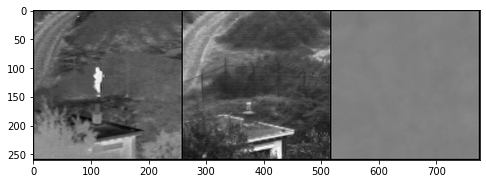

iteration =  100
tensor(113.0185, device='cuda:0', grad_fn=<AddBackward0>)


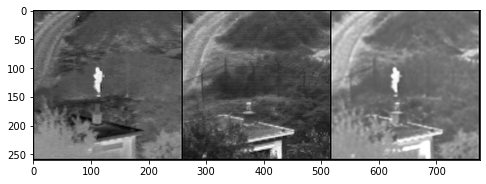

iteration =  200
tensor(102.7691, device='cuda:0', grad_fn=<AddBackward0>)


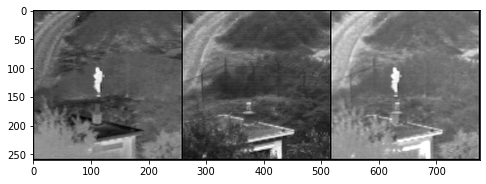

iteration =  300
tensor(96.7577, device='cuda:0', grad_fn=<AddBackward0>)


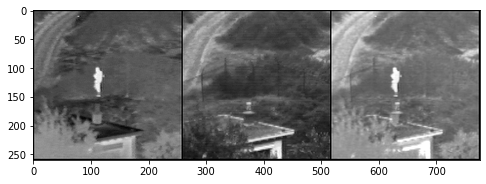

iteration =  400
tensor(93.1171, device='cuda:0', grad_fn=<AddBackward0>)


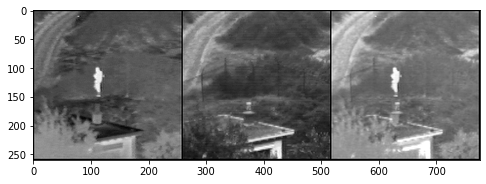

iteration =  500
tensor(89.1936, device='cuda:0', grad_fn=<AddBackward0>)


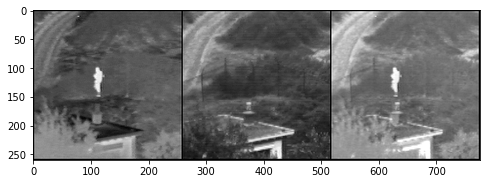

iteration =  600
tensor(87.8307, device='cuda:0', grad_fn=<AddBackward0>)


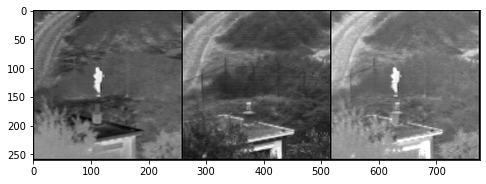

iteration =  700
tensor(87.1321, device='cuda:0', grad_fn=<AddBackward0>)


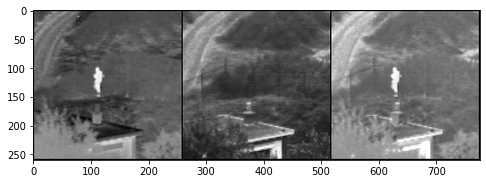

iteration =  800
tensor(84.8478, device='cuda:0', grad_fn=<AddBackward0>)


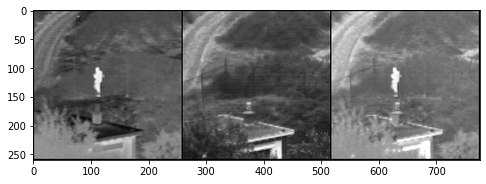

iteration =  900
tensor(85.2233, device='cuda:0', grad_fn=<AddBackward0>)


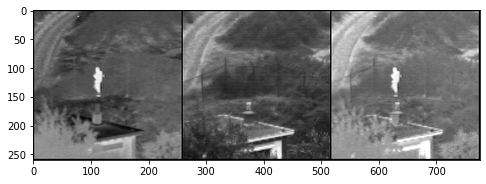

iteration =  1000
tensor(85.5710, device='cuda:0', grad_fn=<AddBackward0>)


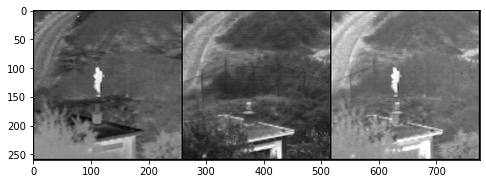

iteration =  1100
tensor(83.2743, device='cuda:0', grad_fn=<AddBackward0>)


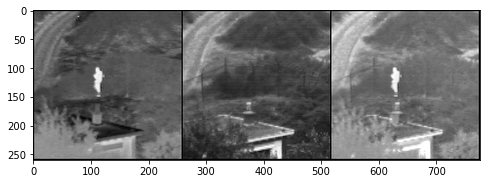

iteration =  1200
tensor(82.1787, device='cuda:0', grad_fn=<AddBackward0>)


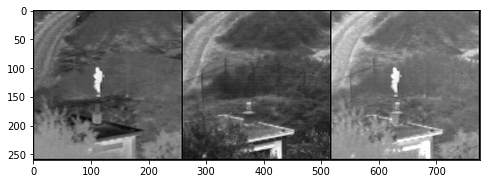

iteration =  1300
tensor(81.3175, device='cuda:0', grad_fn=<AddBackward0>)


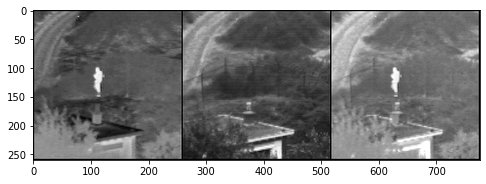

iteration =  1400
tensor(81.6358, device='cuda:0', grad_fn=<AddBackward0>)


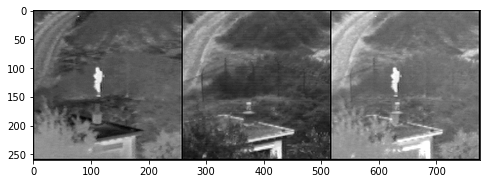

iteration =  1500
tensor(83.9248, device='cuda:0', grad_fn=<AddBackward0>)


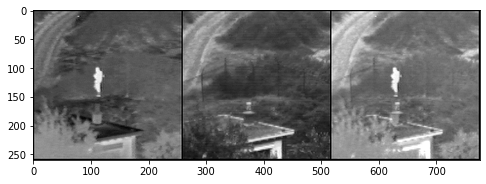

iteration =  1600
tensor(82.0370, device='cuda:0', grad_fn=<AddBackward0>)


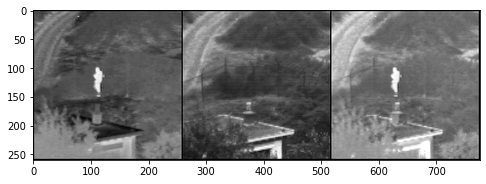

iteration =  1700
tensor(80.2664, device='cuda:0', grad_fn=<AddBackward0>)


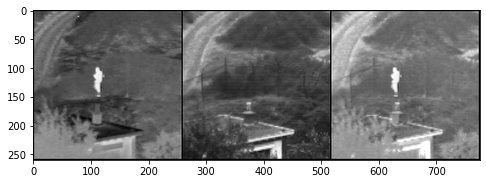

iteration =  1800
tensor(79.5865, device='cuda:0', grad_fn=<AddBackward0>)


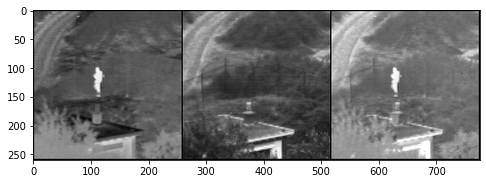

iteration =  1900
tensor(79.5103, device='cuda:0', grad_fn=<AddBackward0>)


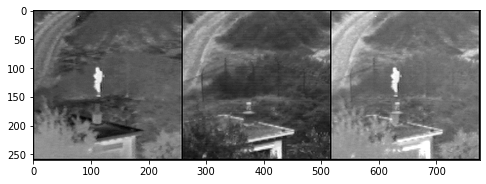

In [76]:
import skimage.restoration as rst

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
out_avg = None
last_net = None
psrn_noisy_last = 0
us_para = 0.5
norm_lambda = 1e-6
best_loss = float('inf')
best_out = None
best_avg = None
no_psf = True
best_i = 0

i = 0
def closure():
    
    global i, out_avg, psrn_noisy_last, last_net, net_input, best_loss, best_out, best_avg, no_psf, channels, best_i

    #xudong avoid start from the previous running result
    # if reg_noise_std > 0:
    #     net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    
    out = net(net_input)
    
    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)

    # #simplest decovolution -- denosing should be operation on observed images rather than output
    # np_out = torch_to_np(out)[0,:,:]
    # deconvolved_out = rst.richardson_lucy (np_out, psf, iterations=20)[None,None,:,:] #denoising
    # deconvolved_out = torch.tensor(deconvolved_out, requires_grad=True).type(dtype).to(device = 'cuda')
    
    #weighting of US and MR  mean square error  
    if out.shape[1] == 1:
        total_loss = torch.norm((us_sg_torch * torch.nn.functional.conv2d(out,us_psf_torch,padding = 2) - us_noisy_torch),p=2) + torch.norm((mr_sg_torch * torch.nn.functional.conv2d(out,mr_psf_torch,padding = 2) - mr_noisy_torch),p=2) 
        # total_loss = mse(us_sg_torch * torch.nn.functional.conv2d(out,us_psf_torch,padding = 2), us_noisy_torch) + mse(mr_sg_torch * torch.nn.functional.conv2d(out,mr_psf_torch,padding = 2), mr_noisy_torch) 
    elif no_psf == False:  #3 channels
        us_r = torch.nn.functional.conv2d(out[0][0].unsqueeze(0).unsqueeze(0),us_psf_torch[0][0].unsqueeze(0).unsqueeze(0),padding = 2)
        us_g = torch.nn.functional.conv2d(out[0][1].unsqueeze(0).unsqueeze(0),us_psf_torch[0][1].unsqueeze(0).unsqueeze(0),padding = 2)
        us_b = torch.nn.functional.conv2d(out[0][2].unsqueeze(0).unsqueeze(0),us_psf_torch[0][1].unsqueeze(0).unsqueeze(0),padding = 2)
        out_us_psf = torch.cat((us_r,us_g,us_b),1)
        # print('out_us_psf.shape:',out_us_psf.shape)
        mr_r = torch.nn.functional.conv2d(out[0][0].unsqueeze(0).unsqueeze(0),mr_psf_torch[0][0].unsqueeze(0).unsqueeze(0),padding = 2)
        mr_g = torch.nn.functional.conv2d(out[0][1].unsqueeze(0).unsqueeze(0),mr_psf_torch[0][1].unsqueeze(0).unsqueeze(0),padding = 2)
        mr_b = torch.nn.functional.conv2d(out[0][2].unsqueeze(0).unsqueeze(0),mr_psf_torch[0][1].unsqueeze(0).unsqueeze(0),padding = 2)
        out_mr_psf = torch.cat((mr_r,mr_g,mr_b),1)
        total_loss = torch.norm((us_sg_torch * out_us_psf - us_noisy_torch),p=2) + torch.norm((mr_sg_torch * out_mr_psf - mr_noisy_torch),p=2) 
    else:
        # print('heerere')
        total_loss = torch.norm((us_sg_torch * out - us_noisy_torch),p=2) + torch.norm((mr_sg_torch * out - mr_noisy_torch),p=2) 
    # total_loss = torch.norm((us_sg_torch * torch.nn.functional.conv2d(out,us_psf_torch,padding = 2) - us_noisy_torch),p=2) + torch.norm((mr_sg_torch * torch.nn.functional.conv2d(out,mr_psf_torch,padding = 2) - mr_noisy_torch),p=2) 
    # total_loss = torch.norm((us_sg_torch * out - us_noisy_torch),p=2) + torch.norm((mr_sg_torch * out - mr_noisy_torch),p=2) 
    # print('loss:',total_loss)
    #Adding norm
    # total_loss += norm_lambda * torch.norm(out, p = 2)
    # print('loss with norm:',total_loss)
    if total_loss < best_loss:
        best_loss = total_loss
        best_out = out
        best_avg = out_avg
        best_i = i
    
    total_loss.backward()
        
    
    ####only us image
    psrn_noisy = compare_psnr(us_noisy_np, out.detach().cpu().numpy()[0]) 
    psrn_gt    = compare_psnr(us_np, out.detach().cpu().numpy()[0]) 
    psrn_gt_sm = compare_psnr(us_np, out_avg.detach().cpu().numpy()[0]) 
    
    # Note that we do not have GT for the "snail" example
    # So 'PSRN_gt', 'PSNR_gt_sm' make no sense
    # print ('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np_avg = torch.mean(out, dim =1).detach().cpu().numpy()
        # plot_image_grid([us_np,mr_np,torch_to_np(out)], factor=figsize, nrow=4)
        # plot_image_grid([np.clip(us_np,0,1),np.clip(mr_np,0,1),np.clip(torch_to_np(out_avg), 0, 1)], factor=figsize, nrow=4)
        print("iteration = ",i)
        print(total_loss)
        if channels != 3:
            plot_image_grid([np.clip(us_np[0][None,:],0,1),np.clip(mr_np[0][None,:],0,1),np.clip(out_np_avg, 0, 1)], factor=figsize, nrow=4)
        else:
            plot_image_grid([np.clip(us_np,0,1),np.clip(mr_np,0,1),np.clip(out_np_avg, 0, 1)], factor=figsize, nrow=4)
        
        
    
    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5: 
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy
            
    i += 1

    return total_loss

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)


Best iteration is:  1933
Best loss is:  tensor(79.1470, device='cuda:0', grad_fn=<AddBackward0>)
Best result as shown below:


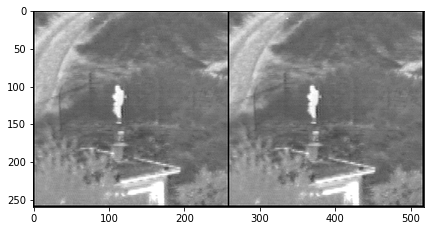

/content/data/data/UN camp/grayUNCamp_input128_128channelavg.png
<PIL.Image.Image image mode=L size=256x256 at 0x7F3337C6E690>
(1, 256, 256)


In [77]:
print("Best iteration is: ",best_i)
print("Best loss is: ",best_loss)
print("Best result as shown below:")

#save best result
if RGB != True:
    best_out_np = torch.mean(best_out, dim =1).detach().cpu().numpy()
    best_avg_np = torch.mean(best_avg, dim =1).detach().cpu().numpy()
    plot_image_grid([best_out_np, best_avg_np], factor=figsize, nrow=4)
    fusion_np = best_out_np
else:
    fusion_np = torch_to_np(best_out)
fusion_pil = np_to_pil(fusion_np)
print(output_path)
fusion_pil.save(output_path)
print(fusion_pil)
# matplotlib.image.imsave('/content/data/data/medical/grayClock_myRGB_nopsf_3_graout.png', gray_fusion,cmap ='gray')
print(fusion_np.shape)

# fusion_avg = torch_to_np(best_avg).transpose(1,2,0)
# plt.imsave('/content/data/data/clocks/grayClock_myRGB_nopsf_1channel.png',fusion)
# plt.imsave('/content/data/data/clocks/grayClock_myRGB_nopsf_avg_1channel.png',fusion_avg)

In [ ]:
#If Fusion RGB same
n = 0
for i in range(fusion.shape[0]):
    for j in range(fusion.shape[1]):
        if fusion[i][j][0] != fusion[i][j][1] or fusion[i][j][0] != fusion[i][j][2] or fusion[i][j][2] != fusion[i][j][1]:
            n += 1
print('number of different RGB is :',n)

number of different RGB is : 262059


In [ ]:
gray_fusion_np = np.mean(fusion, axis=2)[None,:,:]
gray_fusion_pil = np_to_pil(gray_fusion_np)
gray_fusion_pil.save('/content/data/data/clocks/grayClock_myRGB_nopsf_3_graout.png')
print(gray_fusion_pil)
# matplotlib.image.imsave('/content/data/data/clocks/grayClock_myRGB_nopsf_3_graout.png', gray_fusion,cmap ='gray')
# print(gray_fusion.shape)

<PIL.Image.Image image mode=L size=512x512 at 0x7F9481005D10>
(512, 512, 1)


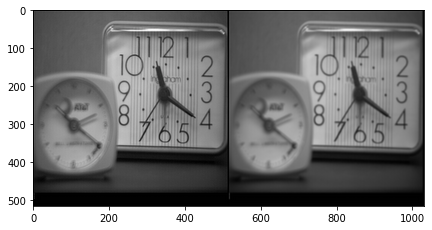

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


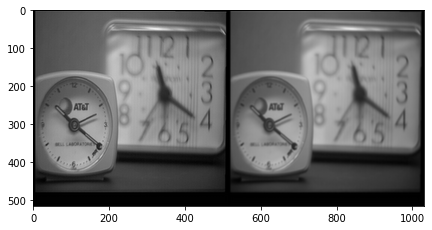

(1, 512, 512)


In [ ]:
#Test simplest deconvolution
import skimage.restoration as rst
us_noisy_pil = crop_image(get_image(fname_us, imsize)[0], d=1)
us_noisy_np = pil_to_np(us_noisy_pil)

mr_noisy_pil = crop_image(get_image(fname_mr, imsize)[0], d=1)
mr_noisy_np = pil_to_np(mr_noisy_pil)

psf = np.ones((5,5))/25

deconvolved_us = rst.richardson_lucy (us_noisy_np[0,:,:], psf, iterations=1)[None,:,:] #deconvolution
deconvolved_mr = rst.richardson_lucy (mr_noisy_np[0,:,:], psf, iterations=1)[None,:,:]

plot_image_grid([us_noisy_np,deconvolved_us], 4, 5)
plot_image_grid([mr_noisy_np,deconvolved_mr], 4, 5)

#original images
o_us_np = us_noisy_np 
o_mr_np = mr_noisy_np

us_noisy_np = deconvolved_us
us_noisy_pil = np_to_pil(deconvolved_us)
mr_noisy_np = deconvolved_mr
mr_noisy_pil = np_to_pil(deconvolved_mr)
print(us_noisy_np.shape)

In [ ]:
#Test
a = torch.randn(1,2,3)
b = torch.randn(1,2,3)
c = a * b #same as np.multiply()
print(a)
print(b)
print(c)
a = np.array([1,2,3,4]).reshape(2,2)
b = np.array([1,2,3,4]).reshape(2,2)
# print(np.dot(a,b))
# print(np.multiply(a,b))

c = np.append(a,b)
c = np.append(c,b)
c = np.array([0.3]*4)

b = np.ones(3)
a = np.random.rand(4,8)
m1 = np.dot(a,a.transpose())
m2 = np.zeros((4,4))

for i in range(a.shape[1]):
    temp_a = a[:,i][:,None]
    m2 += np.dot(temp_a, temp_a.transpose())  

tensor([[[-0.5299,  0.7594,  0.5992],
         [ 1.2207,  0.3775, -1.0931]]])
tensor([[[-1.2411,  1.2493, -0.7270],
         [-0.1303,  0.1323,  0.1134]]])
tensor([[[ 0.6576,  0.9488, -0.4356],
         [-0.1590,  0.0500, -0.1240]]])


In [ ]:
import inspect
# print(inspect.getsource(crop_image))
print(inspect.getsourcefile(crop_image))
print(inspect.getsource(np_to_pil))

/content/utils/common_utils.py
def np_to_pil(img_np): 
    '''Converts image in np.array format to PIL image.
    
    From C x W x H [0..1] to  W x H x C [0...255]
    '''
    ar = np.clip(img_np*255,0,255).astype(np.uint8)
#     ar = img_np.astype(np.uint16)
    
    if img_np.shape[0] == 1:
        ar = ar[0]
    else:
        ar = ar.transpose(1, 2, 0)

    return Image.fromarray(ar)



In [ ]:
out_np = torch_to_np(net(net_input))
# q = plot_image_grid([np.clip(out_np, 0, 1), img_np], factor=13);

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [ ]:
#Test
a = abs(np.random.randn(2,2))
print(a)
b = np.square(a)
c = np.sqrt(b)
print(b)
print(c)


[[2.11873373 1.17488028]
 [0.60581496 0.73377557]]
[[4.48903262 1.38034368]
 [0.36701177 0.53842659]]
[[2.11873373 1.17488028]
 [0.60581496 0.73377557]]


In [ ]:
import matlab.engine
import numpy as np
from utils.common_utils import *
size = 6

a = np.ones(size**2).reshape(size,size)
b = np.ones(size**2).reshape(size,size)
[sg1, sg2] = sensor_gain(a,b,2)

mat_a = matlab.double(a.tolist())
mat_b = matlab.double(b.tolist())

eng = matlab.engine.start_matlab()
beta = eng.SensorGain(mat_a,mat_b) #only return the first variable
print(sg1)
print(beta)


[[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]
[[0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475],[0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475],[0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475],[0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475],[0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475],[0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475,0.7071067811865475]]


(1, 512, 512)
(1, 512, 512)


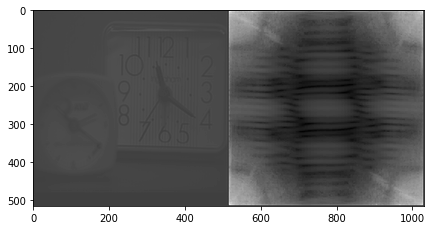

array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 2.05057245e-02, ...,
         1.02547060e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 3.17448162e-04, ...,
         1.04729402e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 

In [ ]:
import numpy as np
from skimage.restoration import (denoise_wavelet, estimate_sigma)
import matplotlib.pyplot as plt

print(us_noisy_np.shape)

# a = np.random.randn(2,3)
a = us_noisy_np
c = np.log(abs(np.fft.fft2(a[0])))
deltaC = c - medfilt2d(c)
lamb = 0.05*abs(deltaC)
r = np.sign(deltaC)*np.maximum(0,abs(deltaC)-lamb)
gr = c - r
# plt.plot(gr)

sigma_est = estimate_sigma(gr) 
im_visushrink = denoise_wavelet(gr, method = 'VisuShrink',mode = 'soft',wavelet_levels = 3,sigma = sigma_est,rescale_sigma=True)[None,:,:]
print(im_visushrink.shape)
plot_image_grid([a,im_visushrink], 4, 5)


In [ ]:

import torch.nn as nn
import torch
 
 
im = torch.randn(1, 1, 5, 5)
print(im.shape)
c = nn.Conv2d(1, 1, kernel_size=2, stride=2, padding=1)
output = c(im)
print(torch.norm(output,p=1))
 


torch.Size([1, 1, 5, 5])
tensor(2.9032, grad_fn=<NormBackward1>)
